<a href="https://colab.research.google.com/github/Juanba98/AdversarialPatch/blob/main/AdversarialPatch_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision  --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [ ]:
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision as TV
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

import math
import PIL
from scipy.ndimage.interpolation import rotate
import torch.nn.functional as F
import paths

# Hyperparameters

In [ ]:
TARGET_LABEL_IDX = 18

#PATCH_SHAPE = (1, 32, 32, 3)

IMAGE_SHAPE = (224,224,3)

PATCH_SHAPE= (3, 125, 125)

EPOCHS = 500

# Data for the transformation of the patch
#SCALE_MIN = 0.9
#SCALE_MAX = 1.4
ROTATE_MAX = np.pi/8 # (-22.5, 22.5)

MAX_ROTATION = 22.5

#Data Set florer
DATA_DIR = paths.DATA_DIR

DATA_DIR_TRAIN =  paths.DATA_DIR_TRAIN
DATA_DIR_VAL =  paths.DATA_DIR_VAL
DATA_DIR_TEST =  paths.DATA_DIR_TEST



## Flowers Mapping

In [ ]:
import json

with open(DATA_DIR + '/flower_to_name.json', 'r') as f:
    flower_to_name = json.load(f)
    
print(len(flower_to_name)) 
print(flower_to_name)


102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

# Load Data

In [ ]:

training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                              std= [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                              std= [0.229, 0.224, 0.225])])


testing_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                                              std= [0.229, 0.224, 0.225])])


training_dataset = datasets.ImageFolder(DATA_DIR_TRAIN, transform=training_transforms)
validation_dataset = datasets.ImageFolder(DATA_DIR_VAL, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(DATA_DIR_TEST, transform=testing_transforms)


BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)







# Building and training the classifier

In [ ]:
model = models.vgg16(pretrained=True)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Build custom classifier
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Function for the validation pass
def validation(model, validateloader, criterion):
    
    val_loss = 0
    n_samples = 0
    n_correct = 0

    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model(images)
        val_loss += criterion(output, labels).item()

        
        _, predictions = torch.max(output,1)
       
     
        n_samples += labels.shape[0]
        
        n_correct += (predictions == labels).sum().item()

   
    accuracy = 100.0 * n_correct / n_samples
       

    return val_loss, accuracy

In [ ]:
# Loss function and gradient descent

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
def train_classifier(epochs,  print_mod, train_loader, validate_loader):
   
  steps = 0
  i = 0

  for e in range(epochs):

    model.train()
    running_loss= 0


    for image, label in iter(train_loader):
      
      image, label = image.to(device), label.to(device)

      steps += 1
      #print(steps)

      optimizer.zero_grad()

     
      output = model(image)
      loss= criterion(output ,label)
      
      loss.backward()
      optimizer.step()


      running_loss+= loss.item()


      if steps % print_mod == 0:
      
                  
        model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            validation_loss, accuracy = validation(model, validate_loader, criterion)

           

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/print_mod),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
              "Validation Accuracy: {:.3f}%".format(accuracy))

        running_loss = 0
        model.train()

STEPS = 15
PRINT_MOD = 40


STEPS
train_classifier(STEPS, PRINT_MOD, train_loader, validate_loader)

Epoch: 1/15..  Training Loss: 5.869..  Validation Loss: 1.723..  Validation Accuracy: 56.357%
Epoch: 1/15..  Training Loss: 2.117..  Validation Loss: 1.009..  Validation Accuracy: 73.350%
Epoch: 2/15..  Training Loss: 0.668..  Validation Loss: 0.765..  Validation Accuracy: 78.484%
Epoch: 2/15..  Training Loss: 1.484..  Validation Loss: 0.640..  Validation Accuracy: 83.496%
Epoch: 2/15..  Training Loss: 1.389..  Validation Loss: 0.609..  Validation Accuracy: 84.841%
Epoch: 3/15..  Training Loss: 1.132..  Validation Loss: 0.554..  Validation Accuracy: 84.352%
Epoch: 3/15..  Training Loss: 1.245..  Validation Loss: 0.501..  Validation Accuracy: 87.042%
Epoch: 4/15..  Training Loss: 0.349..  Validation Loss: 0.488..  Validation Accuracy: 87.775%
Epoch: 4/15..  Training Loss: 1.199..  Validation Loss: 0.536..  Validation Accuracy: 86.675%
Epoch: 4/15..  Training Loss: 1.249..  Validation Loss: 0.448..  Validation Accuracy: 88.264%
Epoch: 5/15..  Training Loss: 0.788..  Validation Loss: 0.43

In [ ]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')
    n_samples = 0
    n_correct = 0
    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model(images)

            _, predictions = torch.max(output,1)
       
     
            n_samples += labels.shape[0]
        
            n_correct += (predictions == labels).sum().item()

   
        accuracy = 100.0 * n_correct / n_samples
        print("Test Accuracy: {}".format(accuracy))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 88.76678876678876


In [ ]:
# Save the checkpoint

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, '/content/drive/MyDrive/TFG/flores/flowers/checkpoint2.pth')
    
save_checkpoint(model)   

In [ ]:
from collections import OrderedDict

# Function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

model = load_checkpoint('/content/drive/MyDrive/TFG/flores/flowers/checkpoint.pth')

model.to(device)
    

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

(3, 224, 224)


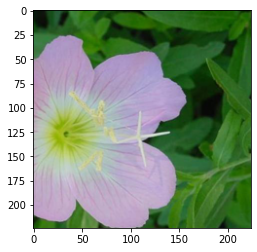

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    print(image.shape)
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image('/content/drive/MyDrive/TFG/flores/flowers/train/1/image_06735.jpg')
imshow(image)

In [ ]:
# Implement the code to predict the class from an image file

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    
    output = model(image)
    probabilities = torch.exp(output)
    _, predicted = torch.max(output.data, 1)
    print('predicted',predicted)
    
    #print(probs)
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = probabilities.topk(topk)
    print(top_probabilities)
    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('/content/drive/MyDrive/TFG/flores/flowers/train/23/image_03369.jpg', model)   



predicted tensor([18], device='cuda:0')
tensor([[1.0000e+00, 5.9324e-19, 4.5721e-21, 1.7013e-22, 9.9329e-23]],
       device='cuda:0', grad_fn=<TopkBackward0>)
{0: '1', 1: '10', 2: '100', 3: '101', 4: '102', 5: '11', 6: '12', 7: '13', 8: '14', 9: '15', 10: '16', 11: '17', 12: '18', 13: '19', 14: '2', 15: '20', 16: '21', 17: '22', 18: '23', 19: '24', 20: '25', 21: '26', 22: '27', 23: '28', 24: '29', 25: '3', 26: '30', 27: '31', 28: '32', 29: '33', 30: '34', 31: '35', 32: '36', 33: '37', 34: '38', 35: '39', 36: '4', 37: '40', 38: '41', 39: '42', 40: '43', 41: '44', 42: '45', 43: '46', 44: '47', 45: '48', 46: '49', 47: '5', 48: '50', 49: '51', 50: '52', 51: '53', 52: '54', 53: '55', 54: '56', 55: '57', 56: '58', 57: '59', 58: '6', 59: '60', 60: '61', 61: '62', 62: '63', 63: '64', 64: '65', 65: '66', 66: '67', 67: '68', 68: '69', 69: '7', 70: '70', 71: '71', 72: '72', 73: '73', 74: '74', 75: '75', 76: '76', 77: '77', 78: '78', 79: '79', 80: '8', 81: '80', 82: '81', 83: '82', 84: '83', 85: 

fritillary
(3, 224, 224)


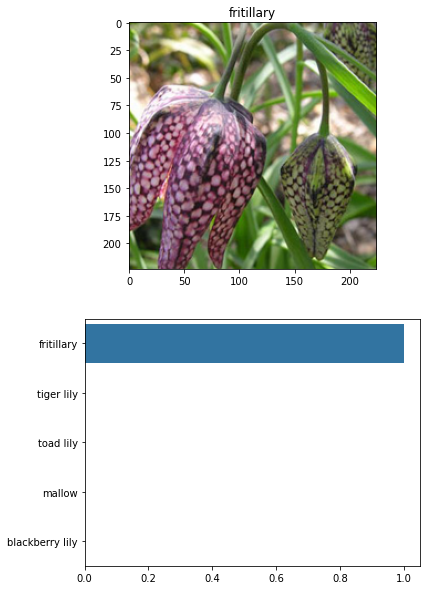

In [ ]:
import seaborn as sb
# Display an image along with the top 5 classes

# Plot flower input image
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

#image = process_image('flowers/test/1/image_06743.jpg')
image = process_image('/content/drive/MyDrive/TFG/flores/flowers/train/23/image_03369.jpg')

flower_title = flower_to_name['23']
print(flower_to_name['23'])

imshow(image, plot_1, title=flower_title);

# Convert from the class integer encoding to actual flower names
flower_names = [flower_to_name[i] for i in classes]

# Plot the probabilities for the top 5 classes as a bar graph
plt.subplot(2,1,2)

sb.barplot(x=probs, y=flower_names, color=sb.color_palette()[0]);

plt.show()

In [ ]:
from PIL import Image as im

idx_to_class = {value: key for key, value in model.class_to_idx.items()}

def _circle_mask(shape, sharpness = 40):

  
  diameter = shape[0]  
  x = np.linspace(-1, 1, diameter)
  y = np.linspace(-1, 1, diameter)
  xx, yy = np.meshgrid(x, y, sparse=True)
  z = (xx**2 + yy**2) ** sharpness

  mask = 1 - np.clip(z, -1, 1)
  mask = np.expand_dims(mask, axis=2)
  mask = np.broadcast_to(mask, shape).astype(np.float32)
  return mask



def create_circular_mask(patch_shape):
 
  mask  = _circle_mask( (patch_shape[-1], patch_shape[-1], 3) )
  
  mask = mask[: , :, :, np.newaxis].transpose(3,2,1,0) 

  return mask, mask.shape
    


def circle_transform(patch, patch_shape, data_shape, image_size):



    # get dummy image 
    x = np.zeros(data_shape)
    y = np.zeros(data_shape)
    # get shape
    m_size = patch_shape[-1]
    

    mask, _  = create_circular_mask((patch_shape[1],patch_shape[2],patch_shape[3]))
    
    
    x_location, y_location = np.random.randint(low=0, high=image_size-patch_shape[-1]), np.random.randint(low=0, high=image_size-patch_shape[-1])   

    for i in range(x.shape[0]):

      # random rotation
      #rot = np.random.choice(360)
      rot = np.random.uniform(-MAX_ROTATION, MAX_ROTATION)

      for j in range(patch[i].shape[0]):
     
      
  
      
        patch[i][j] = rotate(patch[i][j], angle=rot, reshape=False)
       

      # random location
      # apply patch to dummy image  
      x[i, : , x_location:x_location + patch.shape[-1], y_location:y_location + patch.shape[-1]] = patch
      y[i, : , x_location:x_location + patch.shape[-1], y_location:y_location + patch.shape[-1]] = mask
   
    
   
    return x, y, patch.shape, x_location, y_location



train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=1, shuffle=True)
data_iterator = iter(train_loader)
features, labels = data_iterator.next();


patch, patch.shape = create_circular_mask(PATCH_SHAPE)



x, mask, patch_shape , x , y = circle_transform(patch, patch.shape , features.shape, 224)



In [ ]:
import time

def imshow2(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.imshow(out)
    plt.show()

def normalize(image):
   # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std


def attack(image, patch, mask):
   
    model.eval()

    output = model(image)
    x_out = F.softmax(output,dim=1)

    target_prob = x_out.data[0][1]

    #print(x_out.data[0][1])
    #imshow2(image[0].cpu())

    #imshow2(mask[0].cpu())
    
    #imshow2(torch.mul((1-mask), image)[0].cpu())

    #imshow2(torch.mul(mask,patch)[0].cpu())

    adv_x = torch.mul((1-mask), image) + torch.mul(mask,patch)
  
    #imshow2(adv_x[0].cpu())
    
    
    count = 0 
   
    while 0.9 > target_prob:
        #print('T4raget prob', target_prob)
        count += 1


        #imshow2(adv_x[0].cpu())


        adv_x = Variable(adv_x.data, requires_grad=True)
        adv_out = F.log_softmax(model(adv_x))
       
        
        adv_out_probs, adv_out_labels = adv_out.max(1)
        
        #print(TARGET_LABEL_IDX)
        Loss = -adv_out[0][TARGET_LABEL_IDX]
        Loss.backward()
     
        adv_grad = adv_x.grad.clone()
        
        adv_x.grad.data.zero_()
       
        patch -= adv_grad 
        
        #imshow2(torch.mul(mask,patch)[0].cpu())
        
        #print("LOSS", Loss.item())
        
        adv_x = torch.mul((1-mask),image) + torch.mul(mask,patch)
        #imshow2(adv_x[0].cpu())
        #adv_x = torch.clamp(adv_x, 0, 1)
 
        #if count % 10 == 0:
          #print(adv_x.shape)
          #imshow(image, plot_1, title=flower_title);
          #imshow2(adv_x[0].cpu())

        out = F.softmax(model(adv_x))
        target_prob = out.data[0][TARGET_LABEL_IDX]
        
        #y_argmax_prob = out.data.max(1)[0][0]
        
        #print(count, conf_target, target_prob, y_argmax_prob)  

        if count >= 1000:
            break


    return adv_x, mask, patch 


def train(epoch,patch, patch_shape):

  #Ponemos la red en modod evaluacion (inferencia)
  model.eval()
  correct = 0
  total = 0
  
  for i, (images, labels) in enumerate(train_loader):
  

    images, labels = images.to(device),  labels.to(device)
    
  
    prediction = model(images)

    # only computer adversarial examples on examples that are originally classified correctly        
    if prediction.data.max(1)[1][0] != labels.data[0]:
        continue
  
    total += 1 
    
  

    patch, mask, patch_shape, x_location, y_location = circle_transform(patch, patch_shape , images.shape, IMAGE_SHAPE[0])

    patch, mask = torch.FloatTensor(patch), torch.FloatTensor(mask)
    
    patch, mask = patch.cuda(), mask.cuda()

    patch, mask = Variable(patch), Variable(mask)
    

    adv_x, mask, patch = attack(images, patch, mask)
    
    adv_label = model(adv_x).data.max(1)[1][0]
    ori_label = labels.data[0]

    #imshow(adv_x[0].cpu())
    #print("La clase",classes[adv_label])
    #print('ADV label', adv_label )
    #print('Ori label', TARGET_LABEL)
 

    if adv_label == TARGET_LABEL_IDX:
      
      correct += 1
 

      inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255]
      )
      
      #imshow2(images[0].cpu())
      
      inv = inv_normalize(images[0])
      idx_to_class
      # plot source image
      TV.utils.save_image(inv, "/content/drive/MyDrive/TFG/flores/logs/%d_%s_original.png" %(epoch,  idx_to_class[ori_label.item()]))
     

      
      
      inv = inv_normalize(adv_x[0])
     
      # plot adversarial image
      TV.utils.save_image(inv, "/content/drive/MyDrive/TFG/flores/logs/%d_%s_%s_adversarial.png" %(epoch, idx_to_class[ori_label.item()], idx_to_class[adv_label.item()])) 
    
 

    masked_patch = torch.mul(mask, patch)
    
    #imshow2(masked_patch[0].cpu())

    patch = masked_patch.data.cpu().numpy()
    new_patch = np.zeros(patch_shape)


    #print(patch.shape)
    #print(new_patch.shape)
    
 
    '''
    for i in range(new_patch.shape[0]): 
      for j in range(new_patch.shape[1]): 
        new_patch[i][j] = submatrix(patch[i][j])
    
    '''
    
  
    new_patch = patch[:, : , x_location:x_location + patch_shape[-1], y_location:y_location + patch_shape[-1]]

   

    patch = new_patch

    #print(patch.shape)
    #plt.imshow(new_patch[0].transpose(1,2,0))
        # log to file  
        #progress_bar(batch_idx, len(test_loader), "Test Success: {:.3f}".format(success/total))


    return patch

initpatch, patch_shape = create_circular_mask(PATCH_SHAPE)


#plt.imshow(patch[0].transpose(1,2,0))

for epoch in range(1, 200):
  patch = train(epoch,patch, patch_shape)
  inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.255]
      )
  inv = inv_normalize(torch.from_numpy(patch[0]))
  TV.utils.save_image(inv, "/content/drive/MyDrive/TFG/flores/logs/patch%d.png"%(epoch))
        #test(epoch, patch, patch_shape)

#TODO TEST, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
